# Анализ и обработка данных

## Импортирование библиотек

In [32]:
# для работы с датафреймами
import pandas as pd

# для работы с массивами
import numpy as np

# для визуализации результатов
import matplotlib.pyplot as plt

# Импорт необходимых библиотек
import copy
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from dateutil.relativedelta import relativedelta

# Source: https://www.statsmodels.org/stable/install.html
import statsmodels
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Source: https://scikit-learn.org/stable/install.html
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

%matplotlib inline

## Вспомогательные функции

In [33]:
def add_season_column(df, date_column='dt'):
    '''
    Функция для создания колонки 'season' в DataFrame.
    =======
    
    **Args:**
        - `df (pandas.DataFrame)`: Исходный DataFrame
        - `date_column (str, optional (default='dt'))`: Название колонки с датами (должна быть в формате datetime)
        
    **Returns:**
        - `pandas.DataFrame:` DataFrame с добавленной колонкой 'season'.
    '''
    # Получаем месяц из даты
    month = df['month']
    
    # Определяем сезон (0-3)
    season = (
        (month % 12 + 3) // 3 - 1
    ).astype(int)  # математическое определение
    
    df['season'] = season
    return df

## Загрузка данных

**Описание данных:**

    -- 

In [34]:
# читаем train.py
train = pd.read_excel('Data/data/train.xlsx')
# выводим размерность таблицы
print(train.shape)
# выводим первые 5 строк
train.head()

(400, 2)


,dt,Цена на арматуру
0,2015-01-05,32900
1,2015-01-12,32500
2,2015-01-19,32000
3,2015-01-26,30700
4,2015-02-02,30300


In [35]:
train = train.rename(columns={'Цена на арматуру': 'price'})

In [36]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   dt      400 non-null    datetime64[ns]
 1   price   400 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 6.4 KB


In [37]:
train['month'] = train['dt'].dt.month
add_season_column(train)
train['year'] = train['dt'].dt.year
train

,dt,price,month,season,year
0,2015-01-05,32900,1,0,2015
1,2015-01-12,32500,1,0,2015
2,2015-01-19,32000,1,0,2015
3,2015-01-26,30700,1,0,2015
4,2015-02-02,30300,2,0,2015
...,...,...,...,...,...
395,2022-08-01,47500,8,2,2022
396,2022-08-08,49000,8,2,2022
397,2022-08-15,47500,8,2,2022
398,2022-08-22,46500,8,2,2022


In [38]:
train['dt'] = pd.to_datetime(train['dt'])

train = train.set_index('dt')
train.sort_index(inplace=True)
train.head()

,price,month,season,year
dt,,,,
2015-01-05,32900,1,0,2015
2015-01-12,32500,1,0,2015
2015-01-19,32000,1,0,2015
2015-01-26,30700,1,0,2015
2015-02-02,30300,2,0,2015


array([<Axes: xlabel='dt'>, <Axes: xlabel='dt'>, <Axes: xlabel='dt'>,
       <Axes: xlabel='dt'>], dtype=object)

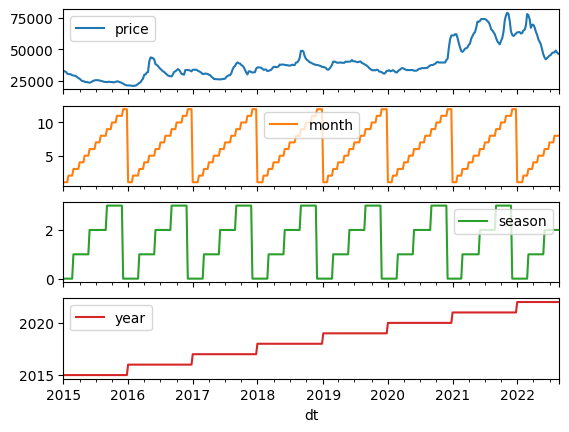

In [39]:
train.plot(subplots=True)

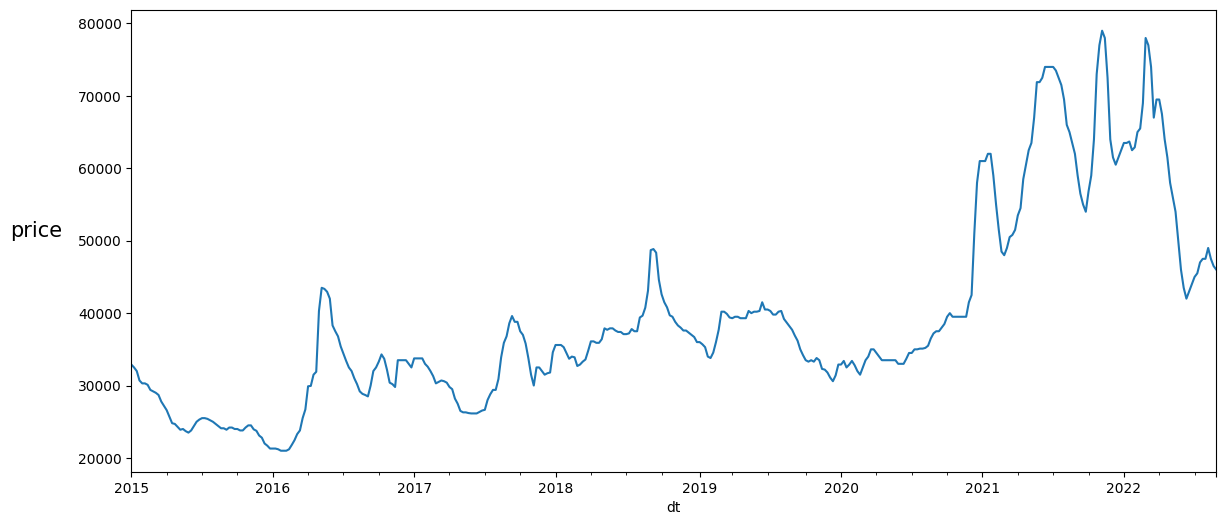

In [40]:
# Рассмотрим изменение цены
plt.figure(figsize=(14, 6))
# plt.title('Time series example')
# plt.xlabel('Date', fontsize=15)
plt.ylabel('price', rotation=0, labelpad=30, fontsize=15)
train['price'].plot();

Вопросы:
- Есть ли у данного ряда тренд? 
- Есть ли у данного ряда сезонность?

<Axes: title={'center': 'Residual'}, xlabel='dt'>

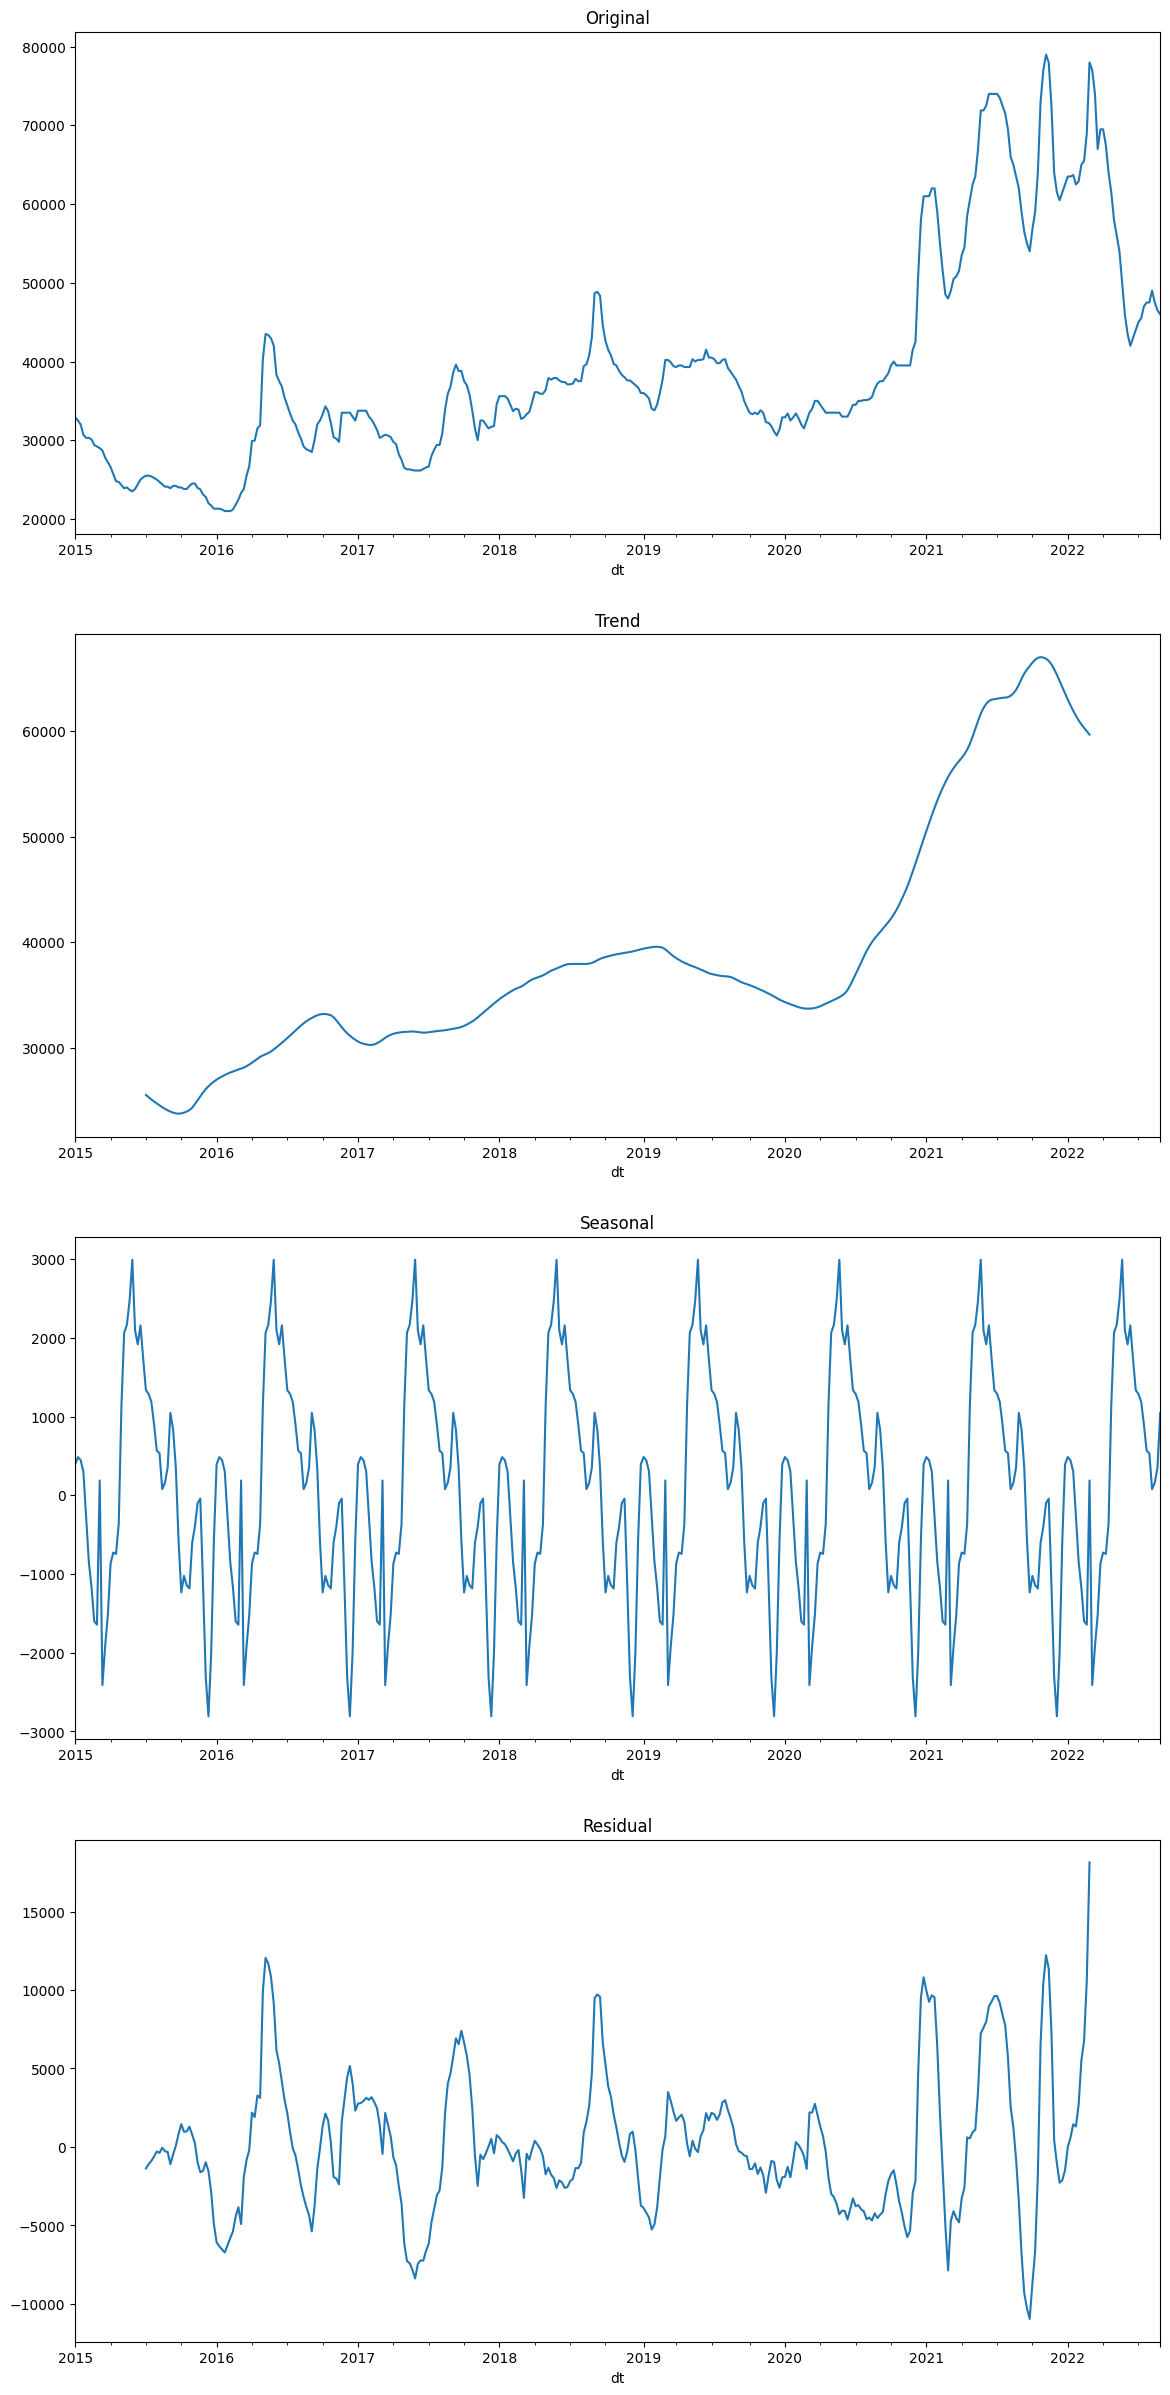

In [41]:
# Разложим ряд на компоненты и проверим ответы на вопросы

fig, ax = plt.subplots(nrows=4, ncols=1, figsize=(14, 30))
decompose = seasonal_decompose(train[['price']])

ax[0].set_title('Original')
ax[1].set_title('Trend')
ax[2].set_title('Seasonal')
ax[3].set_title('Residual')

decompose.observed.plot(ax=ax[0])
decompose.trend.plot(ax=ax[1])
decompose.seasonal.plot(ax=ax[2])
decompose.resid.plot(ax=ax[3])

In [42]:
acf(train['price'], nlags=30, fft=False)

array([1.        , 0.99138242, 0.97367714, 0.95122039, 0.92740427,
       0.90357365, 0.88126621, 0.8606089 , 0.84235253, 0.82671727,
       0.81349611, 0.8020525 , 0.7925797 , 0.78508849, 0.78019657,
       0.77692922, 0.77376814, 0.76901294, 0.76227632, 0.75319077,
       0.74261145, 0.7309889 , 0.71862345, 0.7046383 , 0.68939965,
       0.67325908, 0.65612584, 0.63820561, 0.62109396, 0.60459259,
       0.58872289])

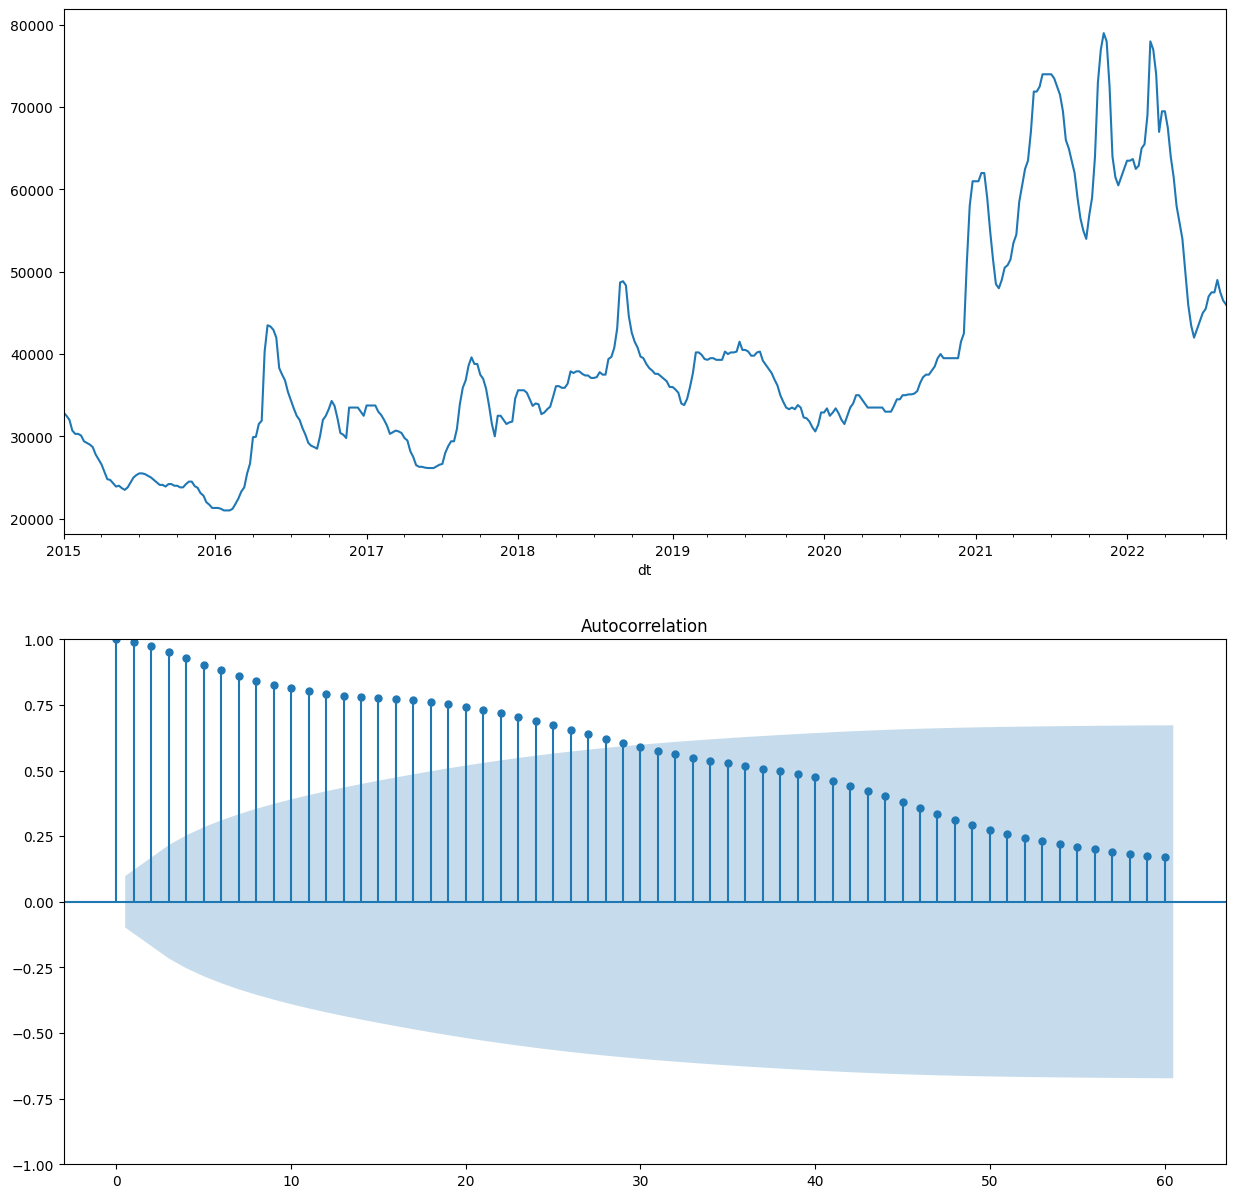

In [43]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(15, 15))
train['price'].plot(ax=ax[0])
plot_acf(train['price'], lags=60, ax=ax[1]);

На втором графике каждый столбец -- значение автокорреляции, а зона, обозначенная синим, говорит о том, является ли определённая автокорреляция значимой (выходит из зоны) или нет (весь столбец находится в закрашенной области)

In [44]:
p_value = adfuller(train['price'])[1]
print(
    f'Полученный уровень значимости (p-value): {round(p_value, 4)}.',
    f'{round(p_value, 4)} > 0.05. Нулевая гипотеза не отвергнута в пользу альтернативной!'
)

Полученный уровень значимости (p-value): 0.32. 0.32 > 0.05. Нулевая гипотеза не отвергнута в пользу альтернативной!


Пробуем привести ряд к стационарному

Шаг 1: Диференцирование

In [45]:
train['price_diff'] = train['price'] - train['price'].shift(1)
train.head()

,price,month,season,year,price_diff
dt,,,,,
2015-01-05,32900,1,0,2015,NaN
2015-01-12,32500,1,0,2015,-400.0
2015-01-19,32000,1,0,2015,-500.0
2015-01-26,30700,1,0,2015,-1300.0
2015-02-02,30300,2,0,2015,-400.0


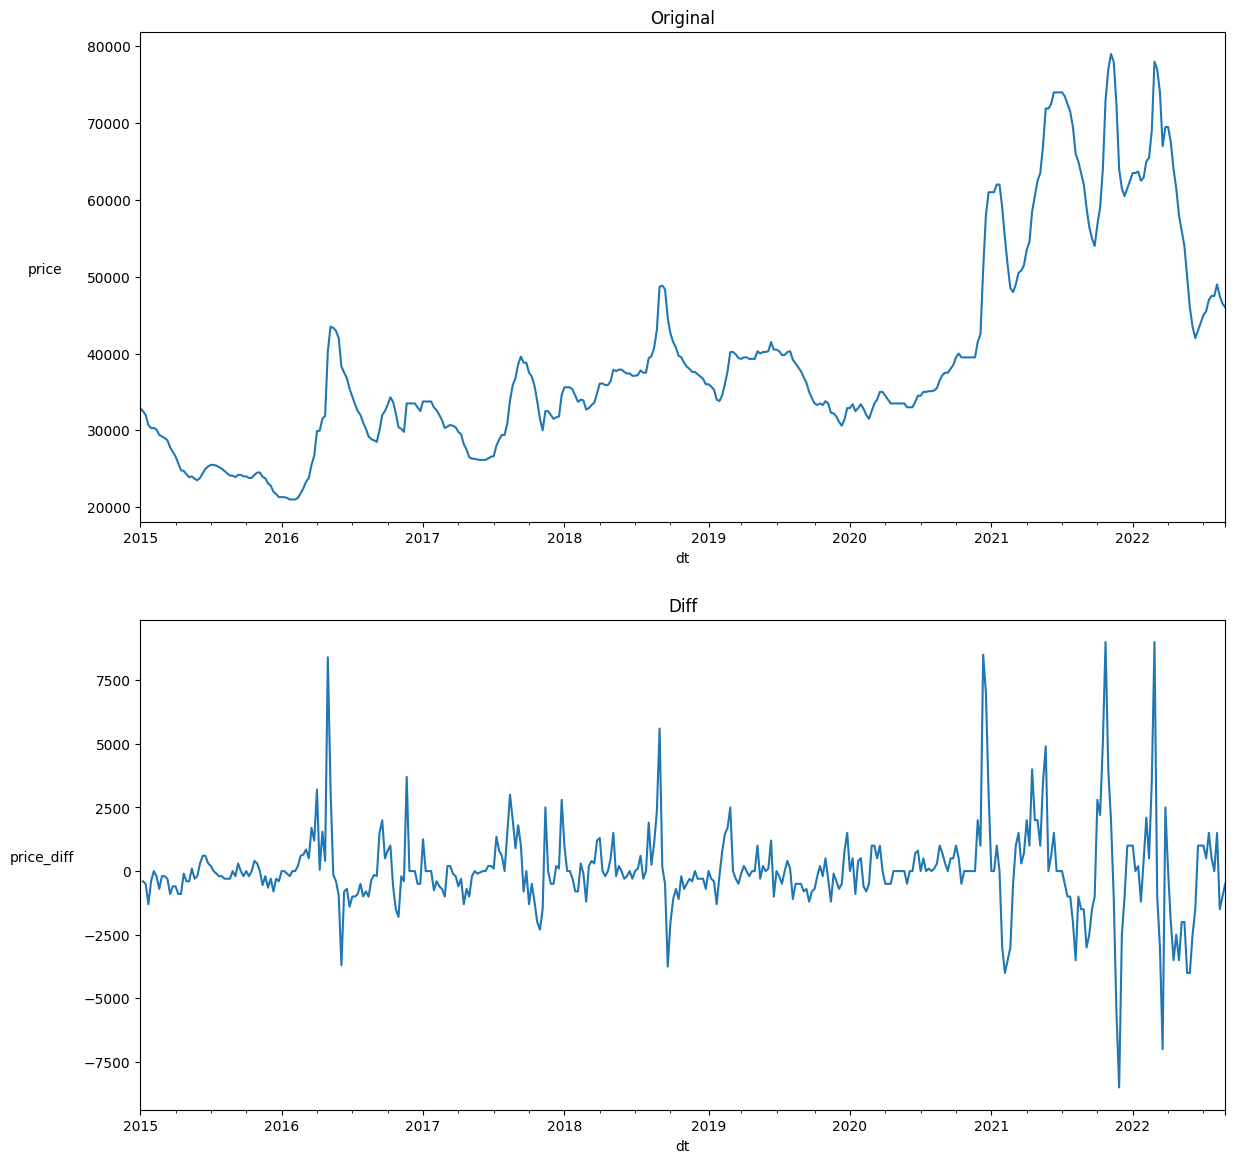

In [46]:
plt.subplots(nrows=2, ncols=1, figsize=(14, 14))

ax = plt.subplot(211)
ax.set_title('Original')
ax.set_ylabel('price', rotation=0, labelpad=30)
train['price'].plot(ax=ax);

ax = plt.subplot(212)
ax.set_title('Diff')
ax.set_ylabel('price_diff', rotation=0, labelpad=30)
train['price_diff'].plot(ax=ax);

In [47]:
# Проверим гипотезы для нового ряда

p_value = adfuller(train['price_diff'][1:])[1]

print(
    f'Полученный уровень значимости (p-value): {round(p_value, 4)}.',
    f'{round(p_value, 4)} < 0.05. Нулевая гипотеза отвергается в пользу альтернативной!'
)


Полученный уровень значимости (p-value): 0.0. 0.0 < 0.05. Нулевая гипотеза отвергается в пользу альтернативной!


In [48]:
train['price_log'] = np.log(train['price'])
train['price_diff_log'] = train['price_log'] - train['price_log'].shift(1)
train.head()

,price,month,season,year,price_diff,price_log,price_diff_log
dt,,,,,,,
2015-01-05,32900,1,0,2015,NaN,10.401228,NaN
2015-01-12,32500,1,0,2015,-400.0,10.388995,-0.012233
2015-01-19,32000,1,0,2015,-500.0,10.373491,-0.015504
2015-01-26,30700,1,0,2015,-1300.0,10.332018,-0.041473
2015-02-02,30300,2,0,2015,-400.0,10.318903,-0.013115


<Axes: title={'center': 'Diff'}, xlabel='dt', ylabel='price_diff_log'>

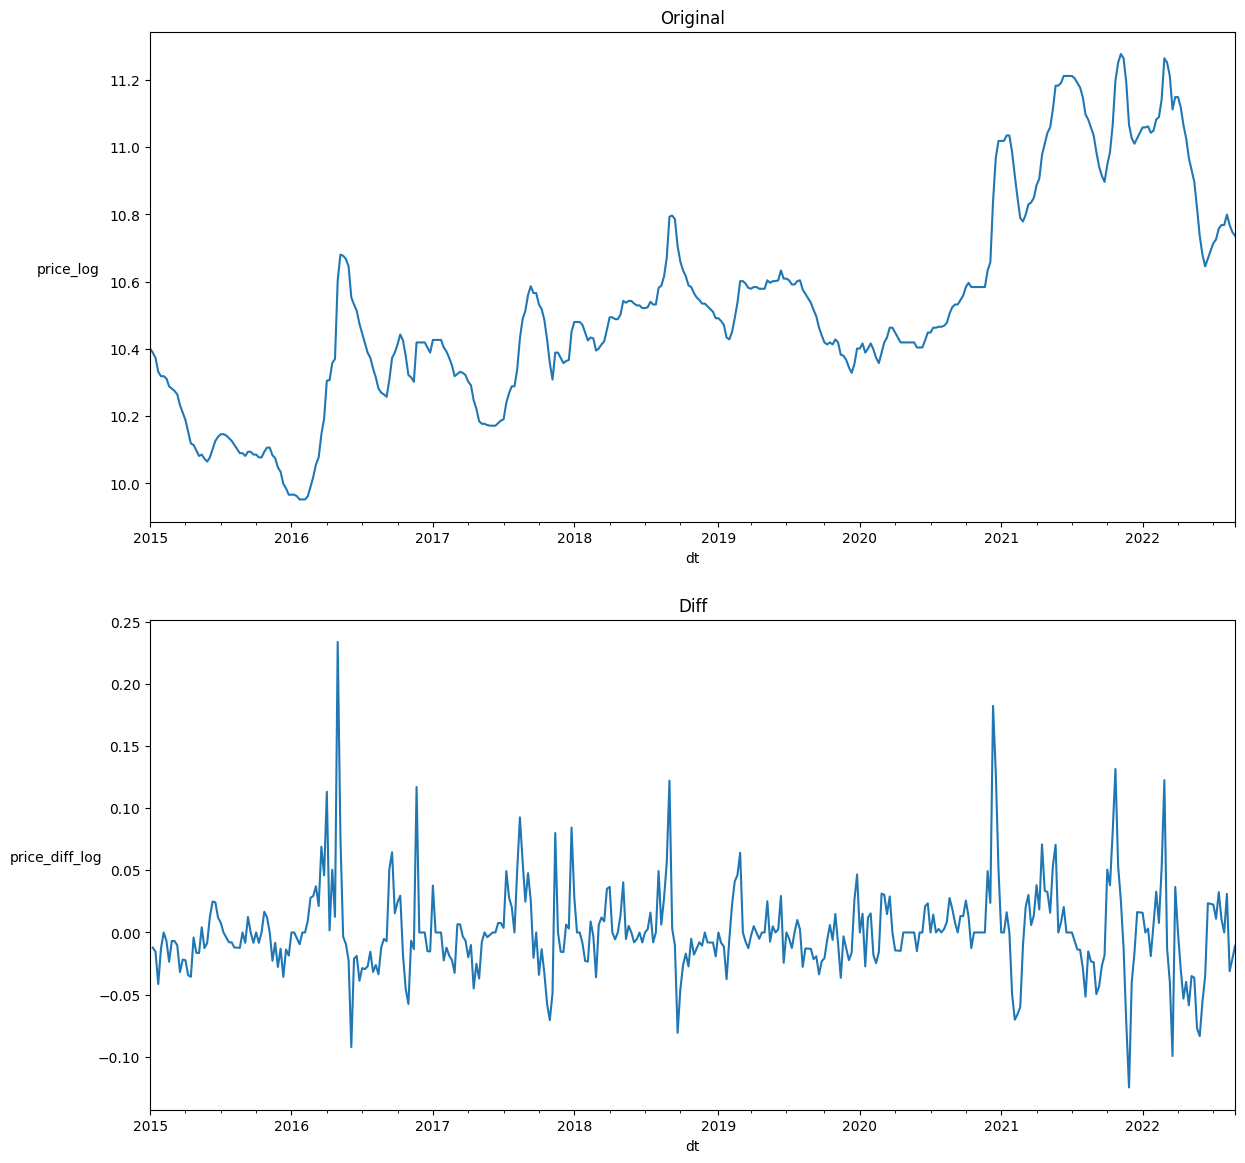

In [49]:
plt.subplots(nrows=2, ncols=1, figsize=(14, 14))

ax = plt.subplot(211)
ax.set_title('Original')
ax.set_ylabel('price_log', rotation=0, labelpad=30)
train['price_log'].plot(ax=ax);

ax = plt.subplot(212)
ax.set_title('Diff')
ax.set_ylabel('price_diff_log', rotation=0, labelpad=30)
train['price_diff_log'].plot(ax=ax)

In [51]:
p_value = adfuller(train['price_diff_log'][1:])[1]

print(
    f'Полученный уровень значимости (p-value): {round(p_value, 4)}.',
    f'{round(p_value, 4)} < 0.05. Нулевая гипотеза отвергается в пользу альтернативной!'
)


Полученный уровень значимости (p-value): 0.0. 0.0 < 0.05. Нулевая гипотеза отвергается в пользу альтернативной!


(array([ 0.27967896,  0.        ,  0.27967896,  0.27967896,  0.55935792,
         0.55935792,  0.83903688,  1.67807377,  1.95775273,  4.19518442,
         5.87325819,  8.94972676, 16.22137976, 29.92564886,  8.94972676,
         8.11068988,  6.15293715,  4.75454234,  2.23743169,  4.19518442,
         0.55935792,  1.39839481,  0.83903688,  0.27967896,  0.27967896,
         0.        ,  0.55935792,  0.55935792,  0.55935792,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.27967896,
         0.        ,  0.        ,  0.        ,  0.        ,  0.27967896]),
 array([-0.12470348, -0.11574226, -0.10678103, -0.09781981, -0.08885858,
        -0.07989736, -0.07093614, -0.06197491, -0.05301369, -0.04405247,
        -0.03509124, -0.02613002, -0.0171688 , -0.00820757,  0.00075365,
         0.00971487,  0.0186761 ,  0.02763732,  0.03659854,  0.04555977,
         0.05452099,  0.06348221,  0.07244344,  0.08140466,  0.09036588,
         0.09932711,  0.10828833,  0.11724955,  0

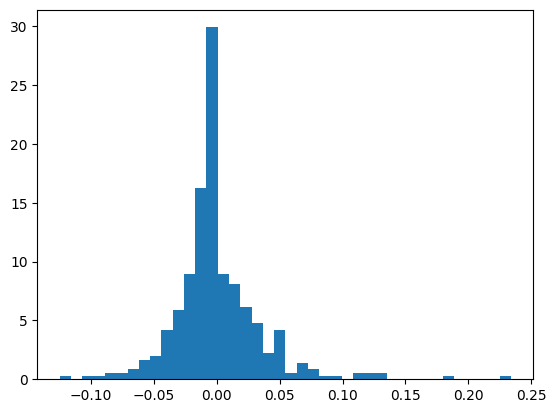

In [53]:
plt.hist(train['price_diff_log'], density=True, bins=40)

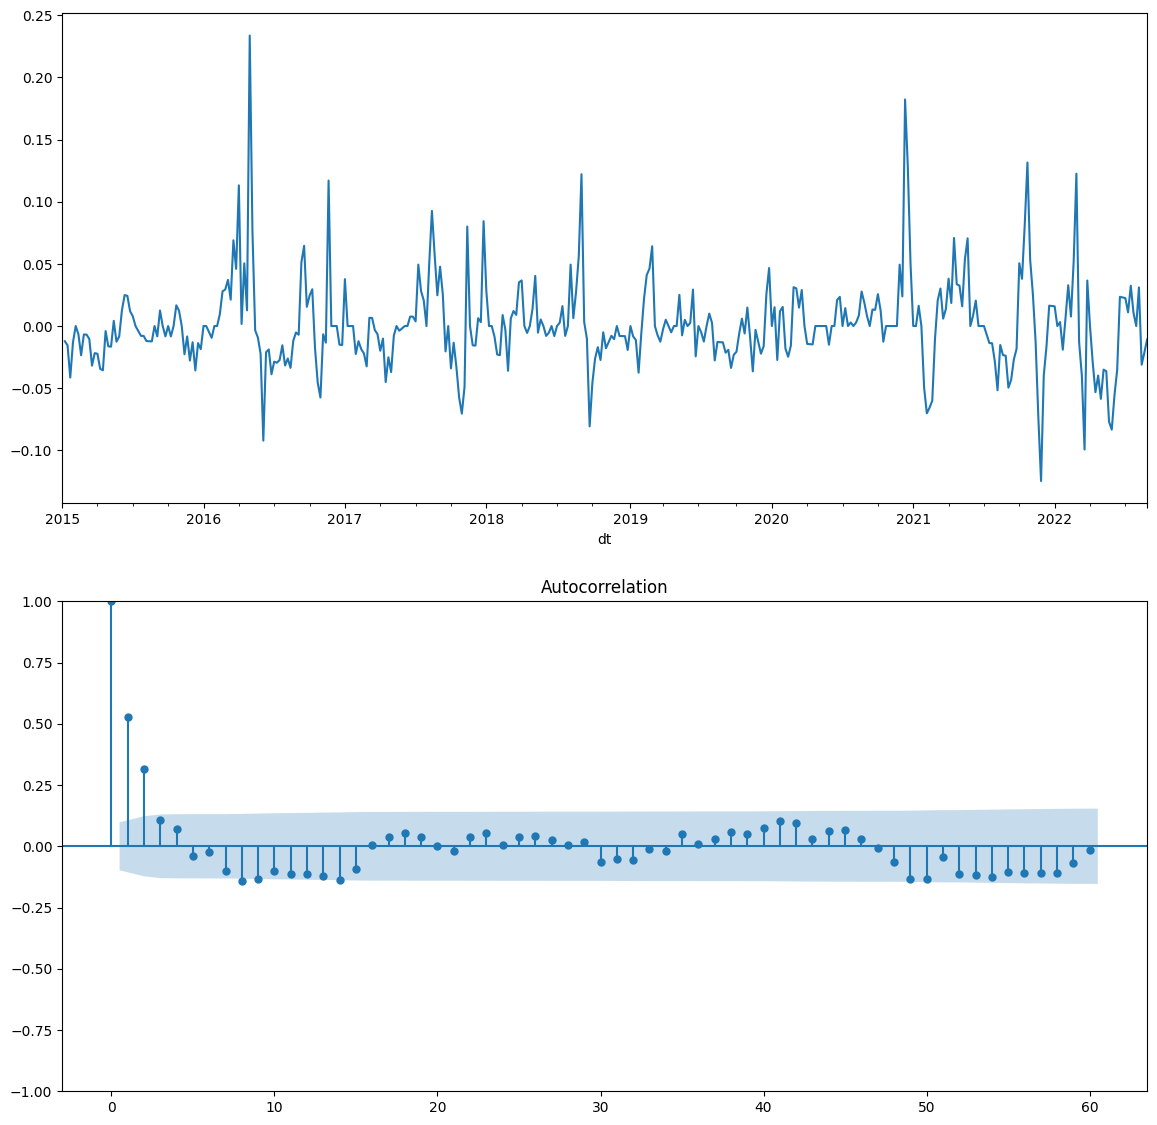

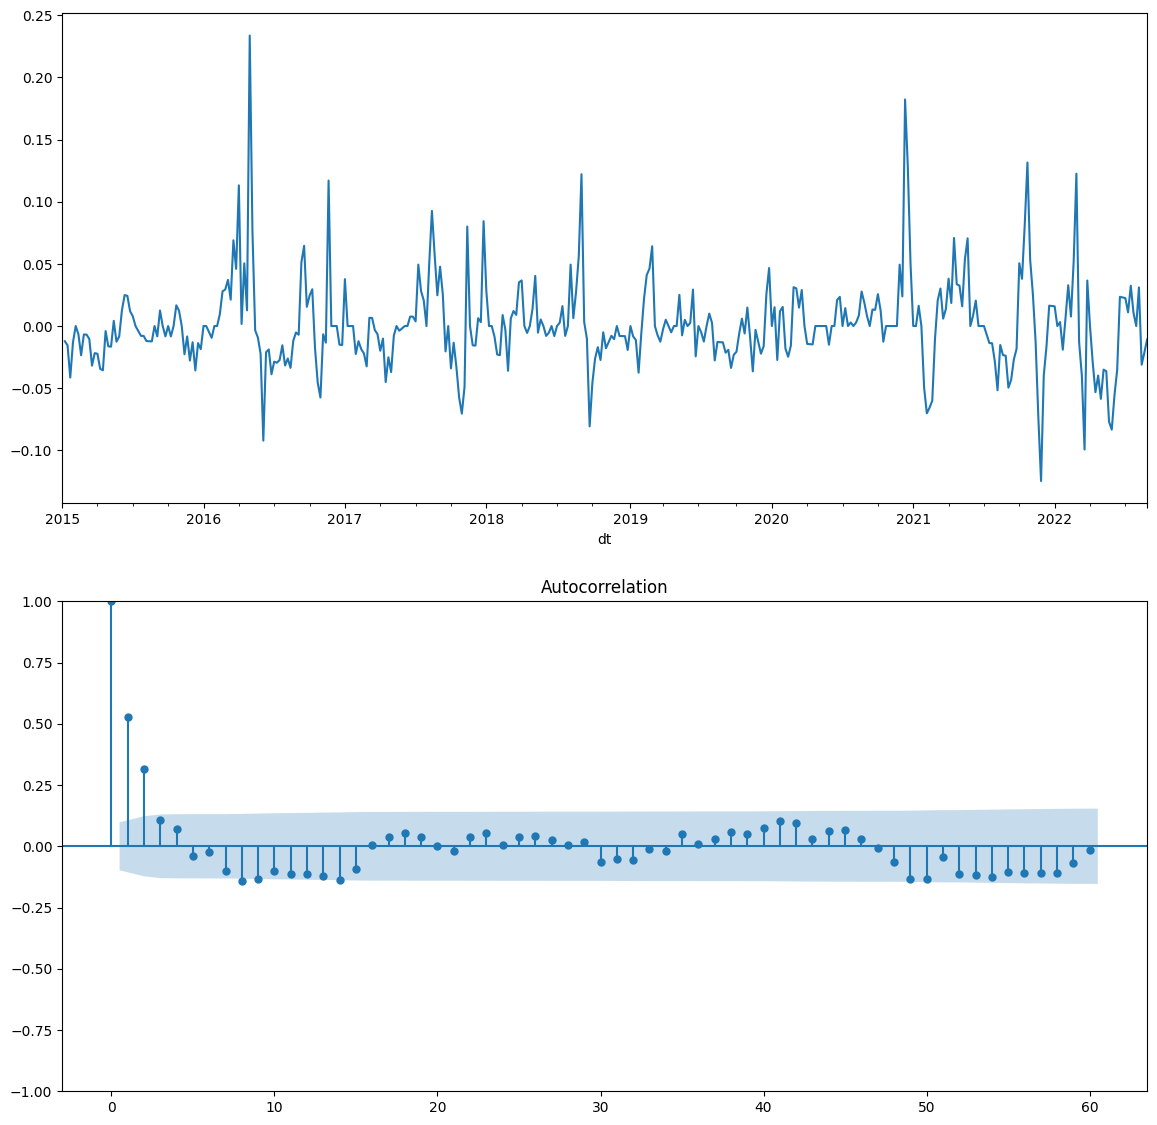

In [55]:
# Построим корелограмму и проверим наличие значимых коррелаций
plt.figure(figsize=(14, 14))

ax = plt.subplot(211)
train['price_diff_log'].plot(ax=ax)

ax = plt.subplot(212)
plot_acf(train['price_diff_log'][1:], lags=60, ax=ax)

In [56]:
from statsmodels.tsa.ar_model import AR